<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

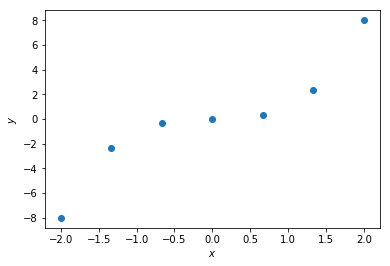

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

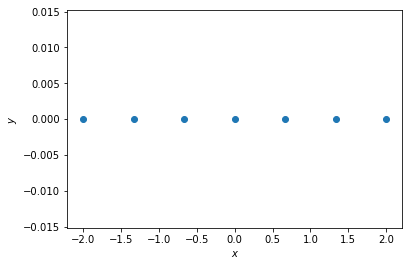

In [48]:
Y=np.mean(np.linspace(-2, 2, 7)**3)
plt.scatter(X, [Y for i in range(7)])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

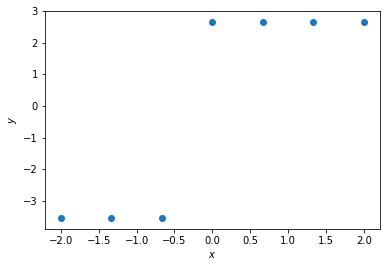

In [13]:
x1=[x**3 for x in X if x<0]
x2=[x**3 for x in X if x>=0]
Y1=[np.mean(x1) for i in range(3)] \
+[np.mean(x2) for i in range(4)]
plt.scatter(X, Y1)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [31]:
def regression_var_criterion(X, t):
    x1=[x for x in X if x<t]
    x2=[x for x in X if x>=t]
    return disp(X)-disp(x1)*len(x1)/len(X)-disp(x2)*len(x2)/len(X)
    
def disp(X):
    yj=0
    for i in range(len(X)):
        yi=0
        for j in range(len(X)):
            yi+=X[j]**3
        yj+=(X[i]**3-yi/len(X))**2
    return yj/len(X)

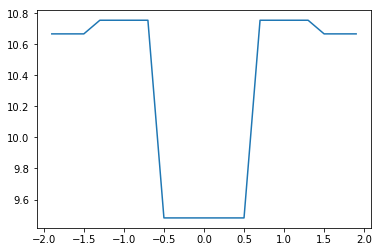

In [39]:
X = np.linspace(-2, 2, 7)
t = np.linspace(-1.9,1.9,20)
# regression_var_criterion(X,1.5)
plt.plot(t, [regression_var_criterion(X,i) for i in t] )

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- <b>Нет</b>

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [52]:
def s_tree(X):
    xt1,xt2,xt3,xt4=[],[],[],[]
    for x in X:
        if x<0:
            if x<-1.5:
                xt1.append(x**3)  
            else:
                xt2.append(x**3) 
        else:
            if x<1.5:
                xt3.append(x**3)  
            else:
                xt4.append(x**3)
    return [np.mean(xt1)]*len(xt1)+[np.mean(xt2)]*len(xt2)+[np.mean(xt3)]*len(xt3)+[np.mean(xt4)]*len(xt4)
    

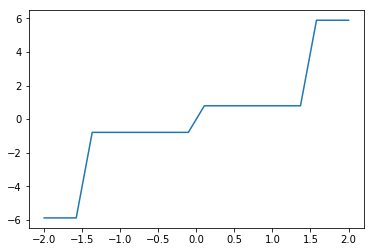

In [55]:
X=np.linspace(-2,2,20)
plt.plot(X,s_tree(X))


**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- <b>7</b>
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [6]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [57]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [116]:
df['age']=(df['age'] // 365.25).astype(int)
dum1=pd.get_dummies(df['gluc'],prefix='gluc')
dum2=pd.get_dummies(df['cholesterol'],prefix='chol')
df=df.drop(['gluc','cholesterol'],axis=1)
result=pd.concat([df,dum1,dum2],axis=1)
test_col=list(result.columns)
test_col.remove('cardio')
result.head(10)


,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,gluc_1,gluc_2,gluc_3,chol_1,chol_2,chol_3
id,,,,,,,,,,,,,,,,
0,50,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0
1,55,1,156,85.0,140,90,0,0,1,1,1,0,0,0,0,1
2,51,1,165,64.0,130,70,0,0,0,1,1,0,0,0,0,1
3,48,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0
4,47,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0
8,59,1,151,67.0,120,80,0,0,0,0,0,1,0,0,1,0
9,60,1,157,93.0,130,80,0,0,1,0,1,0,0,0,0,1
12,61,2,178,95.0,130,90,0,0,1,1,0,0,1,0,0,1
13,48,1,158,71.0,110,70,0,0,1,0,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [117]:
X_train, X_valid, y_train, y_valid = train_test_split(result[test_col],result['cardio'],test_size=0.7,random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [164]:
clf_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
clf_tree.fit(X_train, y_train)
export_graphviz(clf_tree, out_file='../../img/small_tree1.dot', filled=True)

!dot -Tpng '../../img/small_tree1.dot' -o '../../img/small_tree1.png'

"dot" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


In [166]:
test_col[14]

'chol_3'

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [135]:
from sklearn.metrics import accuracy_score

tree_pred = clf_tree.predict(X_valid)
accuracy_score(y_valid, tree_pred)

0.72338775510204079

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [137]:
tree_params = {'max_depth': list(range(2, 11))}
new_tree = DecisionTreeClassifier(random_state=17)
tree_grid = GridSearchCV(new_tree, tree_params,
cv=5)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

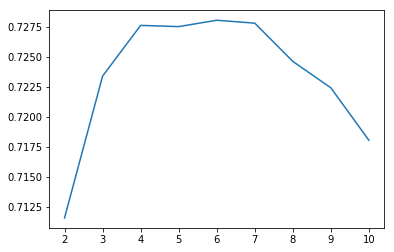

In [141]:
def gr(m):    
    tree_params = {'max_depth': [m]}
    new_tree = DecisionTreeClassifier(random_state=17)
    tree_grid = GridSearchCV(new_tree, tree_params,
    cv=5)
    tree_grid.fit(X_train, y_train)
    tree_pred = tree_grid.predict(X_valid)
    return accuracy_score(y_valid, tree_pred)
plt.plot(range(2,11),[gr(i) for i in range(2,11)])

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [142]:
tree_grid.best_params_

{'max_depth': 4}

In [143]:
tree_pred1 = tree_grid.predict(X_valid)
accuracy_score(y_valid, tree_pred1)

0.72761224489795917

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [10]:
df['age']=(df['age'] // 365.25).astype(int)

In [11]:
def diff_year(x,a,b):
    if x>=a and x<b:
        return 1
    return 0
    

In [31]:
new_df=pd.concat([df['age'].apply(diff_year,args=(45,50)).rename('age45_50'),
                 df['age'].apply(diff_year,args=(50,55)).rename('age50_55'),
                 df['age'].apply(diff_year,args=(55,60)).rename('age55_60'),
                 df['age'].apply(diff_year,args=(60,65)).rename('age60_65')],axis=1)
new1_df=pd.concat([df['ap_hi'].apply(diff_year,args=(120,140)).rename('120_140'),
                 df['ap_hi'].apply(diff_year,args=(140,160)).rename('140_160'),
                 df['ap_hi'].apply(diff_year,args=(160,180)).rename('160_180')],axis=1)
dum2=pd.get_dummies(df['cholesterol'],prefix='chol')
result=pd.concat([new_df,new1_df,dum2,df['smoke'],df['gender'].map({1:0,2:1})],axis=1)
result.head(10)

,age45_50,age50_55,age55_60,age60_65,120_140,140_160,160_180,chol_1,chol_2,chol_3,smoke,gender
id,,,,,,,,,,,,
0,0,1,0,0,0,0,0,1,0,0,0,1
1,0,0,1,0,0,1,0,0,0,1,0,0
2,0,1,0,0,1,0,0,0,0,1,0,0
3,1,0,0,0,0,1,0,1,0,0,0,1
4,1,0,0,0,0,0,0,1,0,0,0,0
8,0,0,1,0,1,0,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,1,0,0
12,0,0,0,1,1,0,0,0,0,1,0,1
13,1,0,0,0,0,0,0,1,0,0,0,0


In [32]:
clf_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
clf_tree.fit(result, df['cardio'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [35]:
export_graphviz(clf_tree, out_file='../../img/result_tree.dot', filled=True)
!dot -Tpng ../../img/result_tree.dot -o ../../img/result_tree.png

In [37]:
result.columns[5]

'140_160'